In [1]:
'''
Generate example images to illustrate different pipeline stages' outputs
'''
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
from lib.combined_threshold import combined_thresh
from lib.undistort_transform import perspective_transform
from lib.fit_line import line_fit, vizualize2, calculate_curve, final_vizualzation


# Read camera calibration coefficients
with open('output_images/calibrate_camera.p', 'rb') as f:
    save_dict = pickle.load(f)
mtx = save_dict['mtx']
dist = save_dict['dist']

# Create example pipeline images for all test images
image_files = os.listdir('test_images')
for image_file in image_files:
    out_image_file = image_file.split('.')[0] + '.png'  # write to png format
    img = mpimg.imread('test_images/' + image_file)

    # Undistort image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    plt.imshow(img)
    plt.savefig('output_images/example/' + out_image_file[:-4] + '_undistort' + out_image_file[-4:])

    # Thresholded binary image
    img, combined2, abs_bin, mag_bin, dir_bin, hls_s_bin, lab_b_bin, hls_l_bin = combined_thresh(img)
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.savefig('output_images/example/' + out_image_file[:-4] + '_binary' + out_image_file[-4:])

    # Perspective transform
    img, binary_unwarped, m, m_inv = perspective_transform(img)
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.savefig('output_images/example/' + out_image_file[:-4] + '_warped' + out_image_file[-4:])

    # Polynomial fit
    ret = line_fit(img)
    left_fit = ret['left_fit']
    right_fit = ret['right_fit']
    nonzerox = ret['nonzerox']
    nonzeroy = ret['nonzeroy']
    left_lane_inds = ret['left_lane_inds']
    right_lane_inds = ret['right_lane_inds']
    save_file = 'output_images/example/' + out_image_file[:-4] + '_polyfit' + out_image_file[-4:]
    vizualize2(img, ret, save_file=save_file)

    # Do full annotation on original image
    # Code is the same as in 'line_fit_video.py'
    orig = mpimg.imread('test_images/' + image_file)
    undist = cv2.undistort(orig, mtx, dist, None, mtx)
    left_curve, right_curve = calculate_curve(left_lane_inds, right_lane_inds, nonzerox, nonzeroy)

    bottom_y = undist.shape[0] - 1
    bottom_x_left = left_fit[0]*(bottom_y**2) + left_fit[1]*bottom_y + left_fit[2]
    bottom_x_right = right_fit[0]*(bottom_y**2) + right_fit[1]*bottom_y + right_fit[2]
    vehicle_offset = undist.shape[1]/2 - (bottom_x_left + bottom_x_right)/2

    xm_per_pix = 3.7/378 # meters per pixel in x dimension
    vehicle_offset *= xm_per_pix

    img = final_vizualzation(undist, left_fit, right_fit, m_inv, left_curve, right_curve, vehicle_offset)
    plt.imshow(img)
    plt.savefig('output_images/example/'  + out_image_file[:-4] + '_annotated' + out_image_file[-4:])

Imposted All Combined Threshold Libraries!
Imported All Undistort Transformation Libraries!


Imposted All Combined Threshold Libraries!
Imported All Undistort Transformation Libraries!
[MoviePy] >>>> Building video output_images/video/project_video_output.mp4
[MoviePy] Writing video output_images/video/project_video_output.mp4


100%|█████████▉| 1260/1261 [06:51<00:00,  3.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/video/project_video_output.mp4 



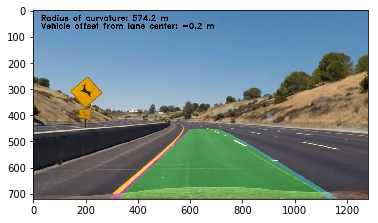

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from lib.line import Line
from lib.fit_line import line_fit, tune_fit, final_vizualzation, calculate_curve, calculate_vehicle_offset
from moviepy.editor import VideoFileClip
from lib.combined_threshold import combined_thresh
from lib.undistort_transform import perspective_transform


# Global variables (just to make the moviepy video annotation work)
with open('output_images/calibrate_camera.p', 'rb') as f:
    save_dict = pickle.load(f)
mtx = save_dict['mtx']
dist = save_dict['dist']
window_size = 12  # how many frames for line smoothing
left_line = Line(window_size=window_size)
right_line = Line(window_size=window_size)
detected = False  # did the fast line fit detect the lines?
left_curve, right_curve = 0., 0.  # radius of curvature for left and right lanes
left_lane_inds, right_lane_inds = None, None  # for calculating curvature


# MoviePy video annotation will call this function
def annotate_image(img_in):
    """
    Annotate the input image with lane line markings
    Returns annotated image
    """
    global mtx, dist, left_line, right_line, detected
    global left_curve, right_curve, left_lane_inds, right_lane_inds

    # Undistort, threshold, perspective transform
    undist = cv2.undistort(img_in, mtx, dist, None, mtx)
    img, combined2, abs_bin, mag_bin, dir_bin, hls_s_bin, lab_b_bin, hls_l_bin = combined_thresh(undist)
    binary_warped, binary_unwarped, m, m_inv = perspective_transform(img)

    # Perform polynomial fit
    if not detected:
        # Slow line fit
        ret = line_fit(binary_warped)
        left_fit = ret['left_fit']
        right_fit = ret['right_fit']
        nonzerox = ret['nonzerox']
        nonzeroy = ret['nonzeroy']
        left_lane_inds = ret['left_lane_inds']
        right_lane_inds = ret['right_lane_inds']

        # Get moving average of line fit coefficients
        left_fit = left_line.add_fit(left_fit)
        right_fit = right_line.add_fit(right_fit)

        # Calculate curvature
        left_curve, right_curve = calculate_curve(left_lane_inds, right_lane_inds, nonzerox, nonzeroy)

        detected = True  # slow line fit always detects the line

    else:  # implies detected == True
        # Fast line fit
        left_fit = left_line.get_fit()
        right_fit = right_line.get_fit()
        ret = tune_fit(binary_warped, left_fit, right_fit)
        left_fit = ret['left_fit']
        right_fit = ret['right_fit']
        nonzerox = ret['nonzerox']
        nonzeroy = ret['nonzeroy']
        left_lane_inds = ret['left_lane_inds']
        right_lane_inds = ret['right_lane_inds']

        # Only make updates if we detected lines in current frame
        if ret is not None:
            left_fit = ret['left_fit']
            right_fit = ret['right_fit']
            nonzerox = ret['nonzerox']
            nonzeroy = ret['nonzeroy']
            left_lane_inds = ret['left_lane_inds']
            right_lane_inds = ret['right_lane_inds']

            left_fit = left_line.add_fit(left_fit)
            right_fit = right_line.add_fit(right_fit)
            left_curve, right_curve = calculate_curve(left_lane_inds, right_lane_inds, nonzerox, nonzeroy)
        else:
            detected = False

    vehicle_offset = calculate_vehicle_offset(undist, left_fit, right_fit)

    # Perform final visualization on top of original undistorted image
    result = final_vizualzation(undist, left_fit, right_fit, m_inv, left_curve, right_curve, vehicle_offset)

    return result


def annotate_video(input_file, output_file):
    """ Given input_file video, save annotated video to output_file """
    video = VideoFileClip(input_file)
    
    annotated_video = video.fl_image(annotate_image)
    annotated_video.write_videofile(output_file, audio=False)

# Annotate the video
annotate_video('video/project_video.mp4', 'output_images/video/project_video_output.mp4')
# annotate_video('video/harder_challenge_video.mp4', 'output_images/video/harder_challenge_video_out.mp4')


# Show example annotated image on screen for sanity check
img_file = 'test_images/test2.jpg'
img = mpimg.imread(img_file)
result = annotate_image(img)
result = annotate_image(img)
result = annotate_image(img)
plt.imshow(result)
plt.show()
plt.savefig('output_images/example/test2_annotated_final.jpg')